# Learning to Learn with Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/Learning2learn/blob/main/Learning2Learn.ipynb)

This notebook aims to recreate the architecture proposed by Verdon et al. in the paper *Learning to learn with quantum neural networks via classical neural networks* [[1]](#1), using **PennyLane** [[2]](#2) and **TensorFlow** [[3]](#3). PennyLane is a cross-platform Python library for differentiable programming of quantum computers, which, in this tutorial will be used to create quantum circuits and interface them with TensorFlow, an open-source platform for machine learning, here used to build a custom model of a Recurrent Neural Network (RNN).

We will start with a brief theoretical overview explaining the problem and the setup used to solve it. After that, we will deep dive into the code to build a fully functioning model, ready to be further developed or customized for your own needs. Without further ado, let's start!

---

### Problem: *Optimization of Variational Quantum Algorithms (VQAs)*

Recently, a big effort by the quantum computing community has been devoted to the study of variational quantum algorithms (VQAs, for short) which leverage quantum circuits with fixed shape but with tunable parameters to solve a desired target task. The idea is similar to classical neural networks, where the weights of the network are optimized during training to perform best in regression or classification tasks. Similarly, once the shape of variational quantum circuit is chosen — something that is very difficult and sensitive to the particular task at hand — its tunable parameters are optimized iteratively by minimizing a cost (or loss) function, which measures how good the quantum algorithm is performing (see [[4]](#4) for a thorough overview on VQAs). 


A major challenge for VQAs relates to the optimization of tunable parameters, which was shown to be a very hard task to perform (a possible challenge is posed by the so called *barren plateaus*). In particular, parameters initialization plays a key role in this scenario, since initializing the parameters in the proximity of an optimal solution leads to faster convergence and better results with respect to random initialization, which could bring the model in a region in parameter space far from any good solution. Thus, a good initialization strategy is crucial to promote the convergence of local optimizers to local extrema and to select reasonably good local minima. Here, by local optimizer, we mean a procedure that moves from one solution to another by small (local) changes in parameter space. These are opposed to global search methods, which take into account the whole (or at least a large section) parameter space to propose a new solution.

One such strategy could come from the classical machine learning literature. 


### Solution: *(Classical) Recurrent Neural Networks* 

By building on results from *meta-learning* literature in Classical ML, authors in [[1]](#1) propose to use a Recurrent Neural Network (RNN) as a black-box controller to optimize the tunable parameters of variational quantum algorithms, as shown in the figure below. The cost function used is the expectation value $\langle H\rangle_{\boldsymbol{\theta}} = \langle \psi_{\boldsymbol{\theta}}| H|\psi_{\boldsymbol{\theta}}\rangle $ of a Hamiltonian $H$ with respect to the parametrized state $|\psi_{\boldsymbol{\theta}}\rangle $ evolved by applying the variational quantum circuit to the zero state.

|  |
|:--|
| <img src="./HybridLSTM.png" alt="Scheme of the RNN architecture, as proposed in [[1]](#1)" width="600"/> | 
| **Recurrent Neural Network Scheme**. Given parameters $\boldsymbol{\theta}_{t-1}$ of the variational quantum circuit, the cost function $y_{t-1}$, and the hidden state of the classical network $h_{t-1}$ at the previous time step, the classical computer (the Recurrent Neural Network) proposes a new guess for the parameters $\boldsymbol{\theta}_t$, which are then fed into the quantum computer (the QAOA circuit) to evaluate the cost function $y_t$. By repeating this cycle a few times, and by training the weights of the recurrent neural network to minimize the loss function $y_t$, a good initialization heuristic is found for parameters $\boldsymbol{\theta}$ of the variational quantum circuit.|

At a given iteration, the RNN receives as input the previous cost function $y_t$ evaluated on the quantum computer, where $y_t$ is the estimate of $\langle H\rangle_{t}$, as well as the parameters $\boldsymbol{\theta}_t$ for which the variational circuit was evaluated. The RNN at this time step also receives information stored in its internal hidden state from the previous time step $m_t$. The RNN itself has trainable parameters $\phi$, and hence it applies the parametrized mapping:  

$$ h_{t+1}, \boldsymbol{\theta}_{t+1} = \text{RNN}_{\phi}(h_{t}, \boldsymbol{\theta}_{t}, y_{t}) $$

which generates a new suggestion for the variational parameters as well as a new internal state. Upon training the weights $\phi$, the RNN eventually learns a good heuristic to suggest optimal parameters for the quantum circuit.  


### VQAs in focus: QAOA for MaxCut
There are multiple VQAs for which this hybrid training routine could be used, some of them directly analyzed in [[1]](#1). In the following, we will only focus on one of such examples, that is the use of the QAOA (Quantum Approximate Optimization Algorithm) for solving the MaxCut problem for graphs. Thus, referring to the picture above, the shape of the variational circuit is the one dictated by the QAOA ansatz, and such a quantum circuit is used to evaluate the cost Hamiltonian $H$ of the MaxCut problem of some graphs.  
If you wish to refresh your memories, check out this great tutorial on how to use QAOA for solving graph problems: https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html

---

**Run cell below only if using this notebook in Colab**  
If you're running this notebook on Colab, you need to run the following cell to install required dependencies.

On the other hand, if you're running this on your personal computer, be sure to have the following packages installed (including the listed standard Python libraries):

* `Numpy`
* `Matplotlib`
* `TensorFlow` (`Keras` is integrated by default if using `TensorFlow 2.x`)
* `PennyLane`
* `NetworkX`

***Note***: Running the whole tutorial requires approx. ~10m.

In [1]:
IS_COLAB = False
if IS_COLAB:
    # TensorFlow is installed by default on Colab 
    !pip install --upgrade pennylane
    !pip install networkx

#### Importing the required packages

As already mentioned at the start of the notebook, we will use *PennyLane* for executing quantum circuits and for integrating seamlessly with *TensorFlow*, which will be used for creating the RNN. 

In [2]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Set the seed for reproducibility of results
# These seeds affect all random functions in this tutorial
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#### Package versions

In [3]:
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pennylane 0.13.0
tensorflow 2.3.1
networkx 2.4
numpy 1.18.1


---

### Generation of training data: graphs

As for any Machine Learning project, the first step is to gather (or in our case create) a good dataset, which will be used to train the model and test its performances. In our case, we are analyzing the MaxCut problem, which deals with the problem of finding a good binary partition of nodes in a *graph*, such that the number of edges *cut* by such separation is maximized. For this reason, we start by generating some random graphs $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs,
- $p$ is the probability of having an edge between two nodes.

In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx. 
    
    Args:
        n_graphs (int): length of final list, that is the number of graphs to generate
        n_nodes (int): number of nodes in each graph
        p_edge (float): Probability of having an edge between two nodes (see Networkx's documentation).
    
    Returns:
        list: list containing the generated graphs
    """
    
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

An example of a random graph generated using the function `generate_graphs` just defined:

Example of a random graph with 7 nodes and 11 edges (p=0.43)


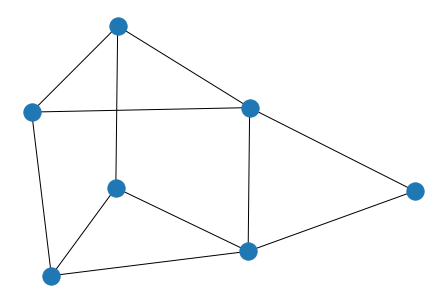

In [5]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Example of a random graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

---

### Variational Quantum Circuit: QAOA  

Now that we have a dataset, we move on by creating the QAOA quantum circuits using PennyLane's built-in sub packages. In particular, using PennyLane's `qaoa` module, we will able to create fully functioning quantum circuits for the MaxCut problem, with very few lines of code.

In [6]:
def qaoa_from_graph(graph, n_layers = 1):
    """Creates a cost function by encoding a Hamiltonian that solves the MaxCut problem using QAOA.

    This function uses nested functions for the creation of the quantum circuit. When called, 
    it instantiates the QAOA circuit for the input graph and outputs a QAOA cost function. 
    Such function, given some parameters, evaluates the MaxCut cost function for the given graph.

    Args:
        graph (networkx.classes.graph.Graph): a graph generated with Networkx
        n_layers (int): number of repetitions in the QAOA ansatz
    
    Returns:
        hamiltonian (function): A function which, given some parameters as input, evaluates the MaxCut QAOA 
        cost function for the specified graph.
    """
        
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits specifically for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
     
    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the MaxCut cost of the QAOA, given the angles for the circuit and the specified graph. 
        
        Args:
            params (list): List of angles for the QAOA circuit, with shape (n_layers x 2). 
                params has the shape [angles_1, ..., angles_(n_layers)], where angles_i = [alphas_i, gammas_i].
        
        Returns:
            cost (function): Cost Hamiltonian evaluated with the input angles
        """
        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        
        # ExpvalCost evaluates the expectation value of an operator
        cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf",  diff_method = "backprop")
        
        return cost(params)
    
    return hamiltonian

Before moving on, let's see how to use these functions.

In [7]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph = graphs[0], n_layers = 1)

# Define some paramenters
# Since we use only one layer in QAOA, params have the shape 1 x 2, in the form [[alpha, gamma]].
# If not specificed, TensorFlow converts Python floating point numbers to tf.float32. 
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Evaluate th QAOA instance just created with some angles.
cost(x)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-3.19326796])>

Now we optimize the parameters to reduce the cost function `cost`. We can do this using `tf.GradientTape()`, which works directly thanks to PennyLane's seamless integration with TensorFlow when using the `default.qubit.tf` device. 

> We use the `Adam` optimizer for its ease of use and good performances on most optimization problems. Feel free to try other optimizers too.

In [8]:
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Choose the number of optimization steps
step = 15

# Start of optimization (or training)
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = cost(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")
    
print(f"\nFinal cost function: {cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = [-3.19326796]
Step 2 - Loss = [-3.82155533]
Step 3 - Loss = [-4.64066003]
Step 4 - Loss = [-5.35547035]
Step 5 - Loss = [-5.68578276]
Step 6 - Loss = [-5.65524931]
Step 7 - Loss = [-5.60867761]
Step 8 - Loss = [-5.70526933]
Step 9 - Loss = [-5.90673464]
Step 10 - Loss = [-6.13248962]
Step 11 - Loss = [-6.32379863]
Step 12 - Loss = [-6.47240742]
Step 13 - Loss = [-6.61170083]
Step 14 - Loss = [-6.77039115]
Step 15 - Loss = [-6.93776967]

Final cost function: [-7.07072686]
Optimized angles: [[0.53574044]
 [1.2945652 ]]


As you can see, the loss function is correctly minimized throughout the optimization process, which eventually yields an optimal value for the angles in the QAOA ansatz. 

---

### Recurrent Neural Network: LSTM  

So far, we have defined the machinery which lets us build the QAOA algorithm for solving the MaxCut problem of a graph.  
Now we wish to implement the Recurrent Neural Network architecture explained previously. In particular, as proposed in the original paper, we will build a custom model of an LSTM (Long-Short Term Memory) network, capable of handling the hybrid data passing between classical and quantum procedures. For this task, we will use `Keras` and `TensorFlow`.  

First of all, let's define the elemental building block of the model, that is an LSTM cell (see [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell) for further details).

In [9]:
# Number of layers in QAOA ansatz. The higher the better in terms of performance, 
# but it also gets more computationally hard. For simplicity, we will stick to the single layer case.
n_layers = 1

# Define a single LSTM cell. The cell has two units per layer
# since each layer in the QAOA ansatz make use of two angles (parameters). 
cell = tf.keras.layers.LSTMCell(2*n_layers)

Using the `qaoa_from_graph` function, we create a list `graph_cost_list` containing the cost functions of a set of graphs. You can see this as a preprocessing step of the data.

In [10]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

At this stage, we seek to reproduce the recurrent behavior depicted in the picture above, outlining the functioning of RNN as a black-box optimizer. We do so by defining two functions:   
- `rnn_iteration`: accounts for the computations happening on a single time step in the figure, that is it performs the calculation inside the CPU and evaluates the quantum circuit on the QPU to obtain the loss function for the current parameters.
- `recurrent_loop`: as the name suggests, it accounts for the creation of the recurrent loop of the model. In particular, it makes consecutive calls to the `rnn_iteration` function, where the outputs of a previous call are fed as inputs of the next call. 

In [11]:
def rnn_iteration(inputs, graph_cost, n_layers = 1):
    """Perform a single time step in the computational graph of the custom RNN. 
    
    The function takes as inputs, the outputs from a previous time step and a graph cost function, 
    and then goes through the Keras' LSTM cell. Its output is used to evaluate the QAOA MaxCut cost function. 
    
    Args:
        inputs (list): List of inputs coming from the previous timestep: cost function, parameters, first LSTM hidden state,
            second LSTM hidden state. 
        graph_cost (function): Cost function of a graph coming from the qaoa_from_graph function
    
    Returns:
        list: A list containing new values for the cost, parameters, and hidden states. 
    """
    # Unpack the input list containing the previous cost, parameters, and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    
    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
    # Call the LSTM cell, which outputs new values for the parameters along with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states = [prev_h, prev_c])
             
    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape = (2, n_layers))
             
    # Evaluate the cost using new angles 
    _cost = graph_cost(_params)
    
    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape = (1,1))
    
    return [new_cost, new_params, new_h, new_c] 

def recurrent_loop(graph_cost, n_layers = 1, intermediate_steps = False):
    """Creates the recurrent loop for the Recurrent Neural Network.
    
    The recurrent loops are created manually by connecting consecutive iterations calls 
    to the custom LSTM model created in `rnn_iteration`.
    
    Args:
        graph_cost (function): Cost function of a graph coming from the qaoa_from_graph function
        intermediate_steps (bool): Boolean flag, set to True if you wish to store values from intermediate iterations

    Returns:
        loss (tf.Tensor): Loss function driving the minimization process
    """
    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape = (1, 1))
    initial_params = tf.zeros(shape = (1, 2*n_layers))
    initial_h = tf.zeros(shape = (1, 2*n_layers))
    initial_c = tf.zeros(shape = (1, 2*n_layers))
    
    # We perform five consecutive calls to 'rnn_iteration', thus creating the recurrent loop.
    # More iterations lead to better results, at the cost of more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    
    # This cost function takes into account the cost from all iteration, but using different weights. 
    loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

#### The cost function
A key part in the `recurrent_loop` function, is given by the definition of the variable `loss`. In order to drive the learning procedure of the weights in the LSTM cell, a cost function is needed. While in the original paper the authors suggest to use a measure called *observed improvement*, for simplicity here we use an easier cost function $\cal{L}(\phi)$ defined as:  

$$\cal{L}(\phi) = {\bf w} \cdot {\bf y}_t(\phi)$$

where ${\bf y}_t(\phi) = (y_1, \cdots, y_5)$ contains the Hamiltonian cost functions from all iterations, and ${\bf w}$ are just some coefficients weighting the different steps in the recurrent loop. In this case, we used ${\bf w}=(0.1, 0.2, 0.3, 0.4, 0.5)$, to give more importance to the last steps rather than the initial steps. Intuitively in this way the RNN is more free (low coefficient) to explore a larger portion of parameter space during the first steps of optimization, while it is constrained (high coefficient) to select an optimal solution towards the end of the procedure.
Note that one could also use just the final cost function from the last iteration to drive the training procedure of the RNN. However, using values also from intermediate steps allows for a smoother suggestion routine, since even non-optimal parameter suggestions from early steps are penalized using $\cal{L}(\phi)$.  

---

### Training

Now all the cards are on the table and we just need to prepare a training routine and then run it!

First of all, let's wrap a single gradient descent step inside a custom function `train_step`.

In [12]:
def train_step(graph_cost):
    """Single optimization step in the training procedure. 
    
    Given the cost/circuit of a graph, it evaluates the corresponding loss and eventually 
    computes the gradients and update the prameters.
    
    Args:
        graph_cost (function): cost function of a graph coming from the qaoa_from_graph function
    
    Returns:
        loss (tf.Tensor): loss for the specified graph, for the current values of the parameters
    """
    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)
        
    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)
    
    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

We are now ready to start the training. In particular, we will perform a stochastic gradient descent in the parameter space of the weights of the LSTM cell. For each graph in the training set, we evaluate gradients and update the weights accordingly. Then, we repeat this procedure for multiple times (epochs).

> For a QAOA ansatz using one single layer, and for a training set of 20 graphs, each epoch takes approximately ~1m to run on a standard laptop. Be careful when using bigger dataset or training for larger epochs.

In [13]:
# Select an optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -1.6641689538955688
 > Graph 6/20 - Loss: -1.4186843633651733
 > Graph 11/20 - Loss: -1.3757232427597046
 > Graph 16/20 - Loss: -1.294339656829834
 >> Mean Loss during epoch: -1.7352586269378663
Epoch 2
 > Graph 1/20 - Loss: -2.119091749191284
 > Graph 6/20 - Loss: -1.4789190292358398
 > Graph 11/20 - Loss: -1.3779840469360352
 > Graph 16/20 - Loss: -1.2963457107543945
 >> Mean Loss during epoch: -1.8252217948436738
Epoch 3
 > Graph 1/20 - Loss: -2.1322619915008545
 > Graph 6/20 - Loss: -1.459418535232544
 > Graph 11/20 - Loss: -1.390620470046997
 > Graph 16/20 - Loss: -1.3165746927261353
 >> Mean Loss during epoch: -1.8328069806098939
Epoch 4
 > Graph 1/20 - Loss: -2.1432175636291504
 > Graph 6/20 - Loss: -1.476362943649292
 > Graph 11/20 - Loss: -1.3938289880752563
 > Graph 16/20 - Loss: -1.3140206336975098
 >> Mean Loss during epoch: -1.8369774043560028
Epoch 5
 > Graph 1/20 - Loss: -2.1429405212402344
 > Graph 6/20 - Loss: -1.477513074874878
 > Graph 1

As you can see, the Loss for each graph keeps decreasing across epochs, indicating that the training routine is working correctly.  

---

### Results

Let's see how to use the optimized RNN as an initializer for the angles in the QAOA algorithm. 

First, we pick a new graph, not present in the training dataset:

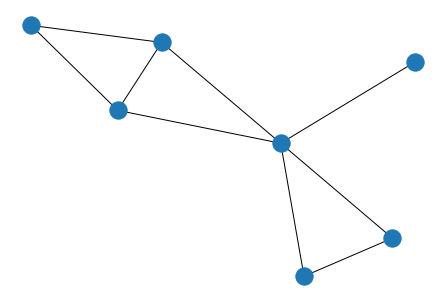

In [14]:
new_graph = nx.gnp_random_graph(7, p = 3/7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

Then we apply the trained RNN to this new graph, saving intermediate results coming from all the recurrent iterations in the network.

In [15]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps = True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape = (2*n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape = (2, n_layers))) for guess in guesses]

#### Plot of the loss function

We can plot these losses to see how well the RNN propose new guesses for the parameters.

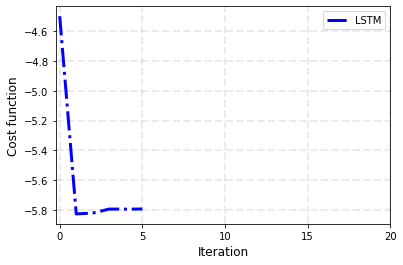

In [16]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
plt.legend()
ax.set_xticks([0,5,10,15,20]);

#### Comparison with standard Stochastic Gradient Descent (SGD)

That's remarkable! The RNN learned to propose new parameters such that the MaxCut cost is minimized very rapidly: in just few iterations the loss reaches a minimum — actually, just after one single step, the LSTM finds a very good minimum. But how well does this method compare with standard optimization techniques, for example, leveraging Stochastic Gradient Descent (SGD) to optimize the parameters in the QAOA?  

Let's check it out. 

In [17]:
# Parameters are randomly initialized
x0 = tf.Variable(np.random.rand(2,1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x0)
        
    steps.append(x0)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x0])
    opt.apply_gradients(zip(gradients, [x0]))
    print(f"Step {_+1} - Loss = {loss}")
    
print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = [-4.1700805]
Step 2 - Loss = [-4.67503588]
Step 3 - Loss = [-5.09949909]
Step 4 - Loss = [-5.40388533]
Step 5 - Loss = [-5.59529203]
Step 6 - Loss = [-5.70495197]
Step 7 - Loss = [-5.7642561]
Step 8 - Loss = [-5.79533198]
Step 9 - Loss = [-5.81138752]
Step 10 - Loss = [-5.81966529]
Step 11 - Loss = [-5.82396722]
Step 12 - Loss = [-5.82624537]
Step 13 - Loss = [-5.82749126]
Step 14 - Loss = [-5.82820626]
Step 15 - Loss = [-5.82864379]
Final cost function: [-5.78429065]
Optimized angles: [[0.53574044]
 [1.2945652 ]]


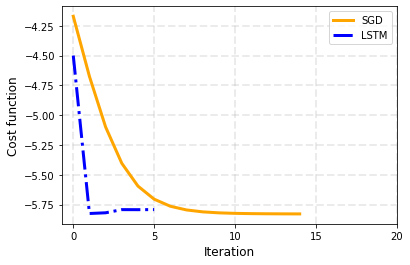

In [18]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color = "orange", lw = 3, label="SGD")

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.legend()
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
ax.set_xticks([0,5,10,15,20]);

*Hurray!* 🎉🎉   
As is it clear from the picture, the RNN reaches a better minimum in fewer (but comparable) iterations than the standard SGD (Stochastic Gradient Descent). Thus, as the authors suggest, the (trained) RNN can be used for few iterations at the start of the training procedure to initialize the parameters of the quantum circuit close to an optimal solution. Then, a standard optimizer like the SGD, can be used to fine-tune the proposed parameters and reach even better solutions.  
While on this small scale example the benefits of using an LSTM to initialize parameters may seem modest, on more complicated instances and problems it can make a big difference, since, on random initialization of the parameters, standard local optimizer may encounter problems finding a good minimization direction (for further details, see [[1,4]](#1)).

#### Loss landscape in parameter space
In addition, we can also plot the path suggested by the RNN in the space of the parameters. Note that this is possible only if one layer is used in the QAOA ansatz since in this case only two angles are needed and they can be plotted on a 2D plane. Of course, if more layers are used, you can always select a pair of them to reproduce a similar plot.

In [19]:
# Note: this cell takes approx. ~1m to run with an 11 by 11 grid

# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1., 1., 11)
dz = np.array([new_cost([[xx],[yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11,11))

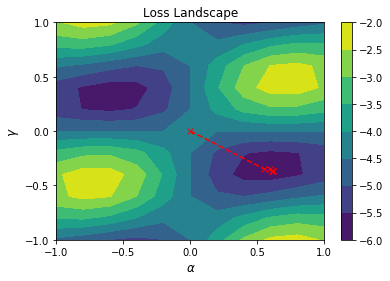

In [20]:
# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.]+[res[i].numpy()[0,0] for i in range(len(res[:-1]))]
params_y = [0.]+[res[i].numpy()[0,1] for i in range(len(res[:-1]))]

# Plot steps
plt.plot(params_x, params_y, linestyle = "--", color = "red", marker = "x")

plt.yticks(np.linspace(-1,1,5))
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r"$\alpha$", fontsize = 12)
plt.ylabel(r"$\gamma$", fontsize = 12)
plt.title("Loss Landscape", fontsize = 12)
plt.show()

--- 

### Generalization performances

A very interesting feature of this model, is that it can be straightforwardly applied to graphs having different number of nodes. In fact, until now our analysis focused only on graphs with the same number of nodes for ease of explanation, and there is no actual restriction in this respect. The same machinery works fine for any graph, since the number of QAOA parameters are only dependent on the number of layers in the ansatz, and not on the number of qubits (equal to the number of nodes in the graph) in the quantum circuit. 

Thus, we might want to challenge our model to learn a good initialization heuristic for a non-specific graph, with an arbitrary number of nodes. For this purpose, let's create a training dataset containing graphs with a different number of nodes $n$, taken in the interval $n \in [7,9]$ (that is, our dataset now contains graphs having either 7, 8 and 9 nodes).

In [21]:
cell2 = tf.keras.layers.LSTMCell(2*n_layers)

g7 = generate_graphs(5, 7, 3/7)
g8 = generate_graphs(5, 8, 3/7)
g9 = generate_graphs(5, 9, 3/7)

gs = g7+g8+g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

# Shuffle the dataset
import random
random.shuffle(gs_cost_list)

So far, we created an equally balanced dataset that contains graphs with different number of nodes. We now use this dataset to train the LSTM.

In [22]:
# Select an optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/15 - Loss: [[-2.3892174]]
 > Graph 6/15 - Loss: [[-2.1072261]]
 > Graph 11/15 - Loss: [[-1.957976]]
 >> Mean Loss during epoch: -2.0667606353759767
Epoch 2
 > Graph 1/15 - Loss: [[-2.3797882]]
 > Graph 6/15 - Loss: [[-2.2293403]]
 > Graph 11/15 - Loss: [[-1.9649515]]
 >> Mean Loss during epoch: -2.117209537823995
Epoch 3
 > Graph 1/15 - Loss: [[-2.3686786]]
 > Graph 6/15 - Loss: [[-2.2524612]]
 > Graph 11/15 - Loss: [[-1.9757932]]
 >> Mean Loss during epoch: -2.1220582803090413


#### Generalization performances

Let's check if this hybrid model eventually learned a good heuristic to propose new updates for the parameters in the QAOA ansatz of the MaxCut problem.  
  

For this reason, we consider a new graph. In particular, we can take a graph with 10 nodes, which is something that the recurrent network has not seen before.

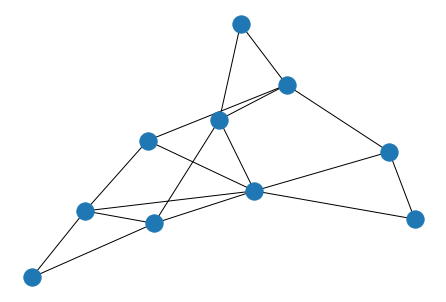

In [23]:
new_graph = nx.gnp_random_graph(10, p = 3/7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

We call the trained recurrent LSTM on this graph, saving not only the last, but all intermediate guesses for the parameters. 

In [24]:
res = recurrent_loop(new_cost, intermediate_steps = True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape = (2*n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape = (2, n_layers))) for guess in guesses]

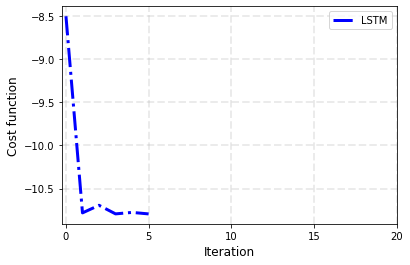

In [25]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.legend()
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
ax.set_xticks([0,5,10,15,20]);

See that the custom optimizer based on the LSTM quickly reaches a good value of the loss function, much faster than  standard stochastic gradient descent.  

To get the optimized weights of the LSTM use:

In [26]:
optimized_weights = cell.get_weights()
print("Trained LSTM weights:\n")
optimized_weights

Trained LSTM weights:



[array([[-0.7376077 , -1.1101236 , -1.0129981 , -0.99815595, -1.3686112 ,
          1.0585576 ,  0.05369393, -0.00978925],
        [ 0.01871599,  0.05814846,  0.08489752,  0.7269866 , -0.00381951,
         -0.60114694, -0.49916103, -0.00289286],
        [-1.1315999 , -0.44949213, -0.21226467, -0.85746855, -0.1839902 ,
          0.73502725, -0.06100825,  1.0624388 ]], dtype=float32),
 array([[ 0.4672368 ,  0.66579676,  0.10499239,  0.22465926,  0.31523764,
         -1.4863725 , -0.8446547 , -0.8977875 ],
        [-0.7462862 , -0.5458552 , -0.09516533, -0.35871622, -0.9762555 ,
          0.7245814 , -0.16661918,  1.1168702 ]], dtype=float32),
 array([ 2.8783693 ,  1.0010815 ,  1.5721463 ,  1.6766872 ,  2.834282  ,
        -1.7745968 ,  1.1729774 ,  0.32245708], dtype=float32)]

To set initial weights for the LSTM cell, use instead: `cell.set_weights(optimized_weights)`.

---  

### Final remarks  

#### Summary
In this tutorial we saw how to use a recurrent neural network, an LSTM in particular, as a black-box optimizer to initialize the parameters in a variational quantum circuit close to an optimal solution. In order to do that, we connected MaxCut QAOA quantum circuits built in PennyLane with an LSTM built with TensorFlow, and we used a custom hybrid training routine to optimize the whole network.  

Such architecture proved itself to be a good candidate for the initialization problem of Variational Quantum Algorithms, since it reaches good optimal solutions in very few iterations. Besides, the architecture is quite general, since the same machinery can be used for graphs having a generic number of nodes.

#### What's next? 
But the story does not end here. There are multiple ways this work could be improved. Here are a few:  

- Use the proposed architecture for VQAs other than QAOA for MaxCut. You can check the paper [[1]](#1) to get some inspiration. 
- Scale up the simulation, using bigger graphs and longer recurrent loops. 
- While working correctly, the training routine is quite basic and it could be improved for example by implementing batch learning or a stopping criterion. Also, one could implement the `observed improvement` loss function, as used in the original paper [[1]](#1).
- Depending on the problem, you may wish to transform the functions `rnn_iteration` and `recurrent_loop` to actual `Keras Layers` and `Models`. This way, by compiling the model before the training takes place, `TensorFlow` can create the computational graph of the model and train more efficiently. If you're interested, you can find some ideas below to start working on it.  

If you have any doubt, or wish to discuss about the project don't hesitate to contact me, I'll be very happy to help you as much as I can 😁  

Have a great quantum day!

---  

#### Ideas for creating a Keras Layer and Keras Model  

Definition of a `Keras Layer` containing a single pass through the LSTM and the Quantum Circuit. That's equivalent to the function `rnn_iteration` from before.

In [27]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p = 1, graph = None):
        super(QRNN, self).__init__()
        # p is the number of layers in the QAOA ansatz
        self.cell = tf.keras.layers.LSTMCell(2*p)
        self.expectation = qaoa_from_graph(graph, n_layers = p)
        self.qaoa_p = p

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]
        
        # Concatenate the previous parameters and previous cost to create new input
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
        # New parameters obtained by the LSTM cell, along with new internal states h and c
        new_params, [new_h, new_c] = self.cell(new_input, states = [prev_h, prev_c])
                
        # This part is used to feed the parameters to the PennyLane function
        _params = tf.reshape(new_params, shape = (2, self.qaoa_p))
                
        # Cost evaluation, and reshaping to be consistent with other Keras tensors
        new_cost = tf.reshape(tf.cast(self.expectation(_params), 
                                      dtype=tf.float32),
                              shape = (1,1))
    
        return [new_cost, new_params, new_h, new_c]

Code for creating an actual `Keras Model` starting from the previous layer definition.

In [28]:
_graph = nx.gnp_random_graph(7, p = 3/7)

# Instantiate the LSTM cells
rnn0 = QRNN(graph = _graph)

# Create some input layers to feed the data
inp_cost = tf.keras.layers.Input(shape = (1,))
inp_params = tf.keras.layers.Input(shape = (2,))
inp_h = tf.keras.layers.Input(shape = (2,))
inp_c = tf.keras.layers.Input(shape = (2,))

# Manually creating the recurrent loops. In this case just three iterations are used.
out0 = rnn0([inp_cost, inp_params, inp_h, inp_c])
out1 = rnn0(out0)
out2 = rnn0(out1)

# Definition of a loss function driving the training of the LSTM
loss = tf.keras.layers.average([0.15 * out0[0], 0.35 * out1[0], 0.5 * out2[0]])

# Definition of a Keras Model
model = tf.keras.Model(inputs=[inp_cost, inp_params, inp_h, inp_c],
                       outputs=[out0[1], out1[1], out2[1], loss])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2)]          0                                            
_______________________________________________________________________________________

A basic training routine for the `Keras Model` just created:

In [29]:
p = 1

inp_costA = tf.zeros(shape = (1, 1))
inp_paramsA = tf.zeros(shape = (1, 2*p))
inp_hA = tf.zeros(shape = (1, 2*p))
inp_cA = tf.zeros(shape = (1, 2*p))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 5

for _ in range(step):
    with tf.GradientTape() as tape:
        pred = model(inputs)
        loss = pred[3]
            
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    print(f"Step {_+1} - Loss = {loss} - Cost = {qaoa_from_graph(_graph, n_layers=p)(np.reshape(pred[2].numpy(),(2, p)))}")
    
print("Final Loss:", loss.numpy())
print("Final Outs:")
for t, s in zip(pred, ["Step 1","Step 2","Step 3","Loss"]):
    print(f" >{s}: {t.numpy()}")

Step 1 - Loss = [[-2.014311]] - Cost = [-6.05823489]
Step 2 - Loss = [[-2.0410357]] - Cost = [-6.1869224]
Step 3 - Loss = [[-2.0691178]] - Cost = [-6.31767668]
Step 4 - Loss = [[-2.099209]] - Cost = [-6.45284001]
Step 5 - Loss = [[-2.1298494]] - Cost = [-6.58368088]
Final Loss: [[-2.1298494]]
Final Outs:
 >Step 1: [[-0.01035318 -0.00192326]]
 >Step 2: [[-0.06707703  0.19985358]]
 >Step 3: [[-0.10908641  0.37953332]]
 >Loss: [[-2.1298494]]


*NOTE:*  
This code works only for a single graph at a time, since a graph was needed to create the `QRNN` `Keras Layer` named `rnn0`. Thus, in order to actually train the RNN network for multiple graphs, the above training routine must be modified. Otherwise, you could find a way to define the model to accept as input a whole dataset of graphs, and not just single one. Still, this might prove particularly hard, since `TensorFlow` deals with tensors, and is not able to directly manage other data structures, like graphs or functions taking graphs as input, like `qoao_from_graph`. 

---

#### References
<a id="1">[1]</a> 
Verdon G., Broughton M., McClean J. R., Sung K. J., Babbush R., Jiang Z., Neven H. and Mohseni M. (2019),  
Learning to learn with quantum neural networks via classical neural networks, [arXiv:1907.05415](https://arxiv.org/abs/1907.05415).

<a id="2">[2]</a> 
https://pennylane.ai/

<a id="3">[3]</a> 
https://www.tensorflow.org/

<a id="4">[4]</a> 
Cerezo M., Arrasmith A., Babbush R., Benjamin S. C., Endo S., Fujii K., McClean J. R., Mitarai K., Yuan X., Cincio L. and Coles P. J. (2020),  
Variational Quantum Algorithms, [arXiv:2012.09265](https://arxiv.org/abs/2012.09265).  